In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1
!pip install scikit-learn==1.2.2 imbalanced-learn==0.10.1

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, balanced_accuracy_score, make_scorer, roc_auc_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

from imblearn.pipeline import Pipeline  # NOTE: using imblearn's pipeline
from imblearn.over_sampling import SMOTE
import shap

import warnings
warnings.filterwarnings("ignore")
from sklearn.exceptions import DataConversionWarning
warnings.filterwarnings("ignore", category=DataConversionWarning)
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 4.3 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.13.0
    Uninstalling imbalanced-learn-0.13.0:
      Successfully uninstalled imbalanced-learn-0.13.0
/kaggle/input/predicting-churn-for-bank-customers/Churn_Modelling.csv


In [2]:


class Bank_Churn():
    """
    A class to represent a customer for churn prediction.
    
    Args:
        df : Bank churn input file
        target_col : target column (churn flag)
        random_state : fixing the randomness for reproducibility
    """
    
    def __init__(self, df : pd.DataFrame, target_col : str, random_state : int):
        #Validate datatypes of arguments when initializing the class
        if not isinstance(df, pd.DataFrame): raise TypeError("Df has to be pandas dataframe")
        else: self.df = df
        if not isinstance(target_col, str): raise TypeError("Target_col has to be str")
        else: self.target_col = target_col

        #Execute method get_viz_bin_dicts
        self.get_viz_bin_dicts()
        
        if not isinstance(random_state, int): raise TypeError("Random_state has to be int")
        else: self.random_state = random_state

    def get_viz_bin_dicts(self):
        """ Create visualization bin dictionary """
        
        #Initialize self.viz_bins_dict
        self.viz_bins_dict = {}

        #Add keys and values into the dictionary for plotting visualization
        self.viz_bins_dict['Age'] = [self.df['Age'].min()-1, 20, 30, 40, 50, 60, 70, 80, 90, 100]
        self.viz_bins_dict['Balance'] = [self.df['Balance'].min()-1, 1, 250, 1000, 5000, 10000, 25000, 50000, 
                                         75000, 100000, 150000, 200000, 250000, 300000]
        self.viz_bins_dict['EstimatedSalary'] = [self.df['EstimatedSalary'].min() - 1, 20000, 40000, 
                                                 60000, 80000, 100000, 120000, 140000, 160000, 180000, 200000]

    def display_viz(self, 
                nlargest : int  = 5, 
                bins : int = 10,
                figsize : tuple = (14, 6),
                gridspec_kw : dict = {'width_ratios': [1.5, 1]},
                palette : str = 'mako',
                fontsize : int = 10
               ):
        """
        To visualize the feature in the dataset using count plot and box plot (applicable when the column data type is numeric).
    
        Args:
            nlargest : Top N to be visualize when the the categorical column has high cardinality.
            bins     : number of bins to cut for columns without bins defined.
            figsize  : Figure size to display the visualization.
            gridspec_kw : the gridspec including width ratios between 2 charts in 1 plot.
            palette : color scheme of the plot.
        
        """
        if not isinstance(nlargest, int): raise TypeError("Nlargest has to be int")
        if not isinstance(bins, int): raise TypeError("Figsize has to be int")
        if not isinstance(figsize, tuple): raise TypeError("Figsize has to be tuple")
        if not isinstance(gridspec_kw, dict): raise TypeError("Figsize has to be dictionary")
        if not isinstance(palette, str): raise TypeError("Figsize has to be string")   
        
        for col in [col for col in self.df.columns if col != self.target_col]:
            if (self.df[col].dtypes == np.int64 and self.df[col].nunique() < 5) or (self.df[col].dtypes == object):
                viz_col = col #Set visualization column
                if self.df[col].dtypes == object:
                    #Identify the top n values
                    top_n = self.df[col].value_counts().nlargest(nlargest).index
    
                    #Filter dataframe with top_n only
                    viz_df = self.df.loc[self.df[col].isin(top_n)]
    
                    #Set the configuration for plotting with single chart.
                    fig, ax1 = plt.subplots(1, 1, figsize=figsize)
                else:
                    viz_df = self.df.copy()
                    #Identify the top n values
                    top_n = self.df[col].value_counts().index
                    if top_n.shape[0] > 2:
                        #Set the configuration for plotting with 2 chart.
                        fig, (ax1, ax2) = plt.subplots(1, 2, figsize = figsize, gridspec_kw = gridspec_kw)
    
                        #Create box plot
                        sns.boxplot(data = viz_df, y = col, x = self.target_col, palette= palette, ax = ax2)
    
                        #Set the title for box plot
                        ax2.set_title(f"Box plot of '{col}' column")
                    else: pass
                        
            else:
                #Bin the numerical feature to categorical feature for visualization
                viz_col = f'{col}_binned' ; df = self.df.copy()
                
                df[f'{col}_binned'] = pd.cut(self.df[col], bins = bins if col not in self.viz_bins_dict.keys() else self.viz_bins_dict[col])
                viz_df = df.copy()
    
                #Identify the top n values
                top_n = viz_df[viz_col].sort_values(ascending = True).unique()
    
                #Set the configuration for plotting with 2 chart.
                fig, (ax1, ax2) = plt.subplots(1, 2, figsize=figsize, gridspec_kw=gridspec_kw)
    
                #Create box plot
                sns.boxplot(data = viz_df, y = col, x = self.target_col, palette= palette, ax = ax2)
    
                #Set the title for box plot
                ax2.set_title(f"Box plot of '{col}' column")
    
            #Create count plot
            ax = sns.countplot(x = viz_col, data = viz_df, order = top_n, palette = palette, hue = self.target_col, ax = ax1)
    
            #Annotate the value for the count plot
            for p in ax.patches:
                count = int(p.get_height())
                ax.annotate(f'{count:,}', 
                            (p.get_x() + p.get_width() / 2., count),  # position at top center of bar
                            ha='center', va='bottom', fontsize = fontsize, fontweight='bold')
    
            #Set the title for the count plot
            ax.set_title(f"Count plot of '{col}' column")
    
            #Rotate the x tick when the feature has high cardinality with more than 5 unique values.
            ax.tick_params(axis = 'x', rotation = 45 if len(top_n) > 5 else 0)
            plt.show()


    def clean_dataset(self):
        """Clean the dataset """

        if self.df.loc[(self.df['Gender'].isin(['Female', 'Male']))].shape[0]:
            self.df['Gender'] = self.df['Gender'].map({'Female' : 0, 'Male' : 1})
        self.X_columns = ['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
        self.Y_column = ['Exited']

    def get_models_parameters(self, model_and_parameters = False):
        if not isinstance(model_and_parameters, (dict, bool)): 
            raise TypeError("Model_and_parameters has to be a dict or bool")

        elif model_and_parameters:
            self.model_and_parameters = model_and_parameters
        else:
            self.models_and_parameters = {
                'Logistic Regression': {
                    'model': LogisticRegression(max_iter=1000, random_state = self.random_state, n_jobs = -1, verbose = 0),
                    'params': {
                        'classifier__C': [0.1, 1, 10],
                        'classifier__penalty': ['l2', 'l1'],
                        'classifier__solver': ['liblinear']
                    }
                },
                'SVM': {
                    'model': SVC(probability=True, random_state = self.random_state, max_iter = -1, verbose = 0),
                    'params': {
                        'classifier__C': [0.1, 1, 5, 8, 10], #, 1, 5, 10, 20],
                        'classifier__kernel': ['linear', 'rbf', 'poly']
                    }
                },
                'Random Forest': {
                    'model': RandomForestClassifier(random_state = self.random_state, warm_start=True,  n_jobs = -1, verbose = 0),
                    'params': {
                        'classifier__n_estimators': [50, 75, 100],
                        'classifier__max_depth': [None, 5, 10],
                        'classifier__min_samples_leaf': [1, 2, 4],
                    }
                },
                'LightGBM': {
                    'model': LGBMClassifier(random_state = self.random_state, n_jobs = -1, verbose = 0),
                    'params': {
                        'classifier__n_estimators': [25, 50, 75],
                        'classifier__num_leaves': [3, 5, 7],
                        'classifier__learning_rate' : [0.1, 0.2]
                    }
                },
                'XGBoost': {
                    'model': XGBClassifier(random_state = self.random_state, n_jobs = -1),
                    'params': {
                        'classifier__n_estimators': [100, 200],
                        'classifier__max_depth': [3, 5]
                    }
                }
            }

    def feature_engineering(self, test_size : float  = 0.2, add_stratify_col_lst : list = ['Gender']):

        
        """ 
        
        Feature engineering on the dataset including Min Max Scaling and One Hot Encoding

        Args:
            test_size : Ratio of the dataset to split to test_size.
            add_stratify_col_lst : Additional column to use as stratify besides target_col.
             
        """

        if not isinstance(test_size, float): raise TypeError("Test_size has to be float")
        if not isinstance(add_stratify_col_lst, list): raise TypeError("add_stratify_col_lst has to be list")
            
        #Identify numerical feature by datatype
        self.numerical_features = self.df[self.X_columns].select_dtypes([int, float]).columns.tolist()

        #Identify categorical feature by datatype
        self.categorical_features = self.df[self.X_columns].select_dtypes(['object']).columns.tolist()

        #Performing scaling on numerical feature and one hot encoding on cateogircal feature
        self.numerical_transformer = Pipeline(steps = [
                                                    ('scaler', MinMaxScaler())
                                               ])
        
        self.categorical_transformer = Pipeline(steps=[
                                                    ('encoder', OneHotEncoder())
                                                 ])
        
        # Combine into a preprocessor
        self.preprocessor = ColumnTransformer(transformers=[
            ('num', self.numerical_transformer, self.numerical_features),
            ('cat', self.categorical_transformer, self.categorical_features)
        ])
        
        
        #Split datasets
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split(self.df[self.X_columns], self.df[self.Y_column], 
                                                                                test_size = test_size, random_state = self.random_state, 
                                                                                stratify = self.df[add_stratify_col_lst + self.Y_column])

    def model_training(self, cv= 5, scorer = roc_auc_score, target_names = ['Not Churn', 'Churn'], verbose = 0):
        """ 
        
        Model training and evaluation with Hyperparameter Tuning and Cross Validation

        Args:
            cv : Number of cross validation required
            scorer : The score required for grid search.
            target_names : The string for visualization on the classification report
            verbose : To display the grid search logs.
            
        """

        if not isinstance(cv, int): raise TypeError("Cv has to be int")
        if not isinstance(target_names, (list, tuple)): raise TypeError("Target_names has to be list or tuple")
        if not isinstance(verbose, int): raise TypeError("Verbose has to be int")
            
        # Use balanced accuracy as the scoring metric
        self.scorer = make_scorer(scorer)
        
        for name, cfg in self.models_and_parameters.items():
            print(name)
            #Setup the pipeline preprocessing, smote and model
            self.clf_pipeline = Pipeline(steps=[
                ('preprocessor', self.preprocessor),
                ('smote', SMOTE(random_state = self.random_state)),
                ('classifier', cfg['model'])
            ])
            
            #Grid Search to identify best hyperparameter tuning.
            self.grid_search = GridSearchCV(self.clf_pipeline, cfg['params'], cv = cv, scoring = self.scorer, n_jobs=-1, verbose = verbose)
            self.grid_search.fit(self.X_train, self.y_train.values)
        
            # Best model
            self.best_model = self.grid_search.best_estimator_
        
            # CV
            print("CV Results:")
            
            self.y_train_pred = self.best_model.predict(self.X_train)
            self.y_train_proba = self.best_model.predict_proba(self.X_train)[:, 1]
            
            print(classification_report(self.y_train, self.y_train_pred, target_names = target_names))
            
            balanced_acc = balanced_accuracy_score(self.y_train, self.y_train_pred)
            print(f"Balanced Accuracy: {balanced_acc:.4f}")
            print(f"ROC AUC: {roc_auc_score(self.y_train, self.y_train_proba):.4f}")
        
            # Evaluate
            print("Test Set Results:")
            self.y_pred = self.best_model.predict(self.X_test)
            self.y_proba = self.best_model.predict_proba(self.X_test)[:, 1]
            print(classification_report(self.y_test, self.y_pred, target_names=['Not Churn', 'Churn']))
        
            balanced_acc = balanced_accuracy_score(self.y_test, self.y_pred)
            print(f"Balanced Accuracy: {balanced_acc:.4f}")
            print(f"ROC AUC: {roc_auc_score(self.y_test, self.y_proba):.4f}")


    def model_explainability(self):
        """ Model explanaibility using Feature Importance & Shap """
        
        self.clf_pipeline.fit(self.X_train, self.y_train)

        #Identify the scaled X_test values
        X_test_scaled = self.clf_pipeline[:-2].transform(self.X_test)

        #Use tree explainer for explanation
        self.explainer = shap.TreeExplainer(self.best_model.named_steps['classifier'])

        #Get Shap value for the scaled features since the model was trained with scaled values.
        self.shap_values = self.explainer.shap_values(X_test_scaled)

        #Identify the original values of the features in test set, not the scaled features
        self.test_hot_encoded_df = pd.concat([self.X_test[self.numerical_features].reset_index(drop = True), 
                                              pd.DataFrame(X_test_scaled[:, -3:], columns = ['Geography_France', 'Geography_Germany','Geography_Spain']
                                                           ).reset_index(drop = True) ], axis = 1)

        print('\nGlobal Feature Importance')
        display(shap.summary_plot(self.shap_values, 
                          features= self.test_hot_encoded_df)
               )
        self.y_test_reset_index_df = self.y_test.reset_index(drop = True)

        #Sampling non-churned customer in test set
        self.non_churn_sample_index = self.y_test_reset_index_df.loc[self.y_test_reset_index_df['Exited'] == 0].index[0]

        #Sampling churned customer in test set
        self.churn_sample_index = self.y_test_reset_index_df.loc[self.y_test_reset_index_df['Exited'] == 1].index[4]
        
        shap.initjs()

        print('\nLocal Feature Importance - Non Churned Customer')
        display(shap.force_plot(
                self.explainer.expected_value, # model baseline prediction
                self.shap_values[self.non_churn_sample_index],  # SHAP values for this row
                self.test_hot_encoded_df.iloc[self.non_churn_sample_index]  # original feature values (for display)
            ))

        print('\nLocal Feature Importance - Churned Customer')
        display(shap.force_plot(
                self.explainer.expected_value, # model baseline prediction
                self.shap_values[self.churn_sample_index], # SHAP values for this row
                self.test_hot_encoded_df.iloc[self.churn_sample_index] # original feature values (for display)
            ))
        #Plot feature importance of the most recent model
        importances = self.best_model.named_steps['classifier'].feature_importances_
        
        feat_importance = pd.DataFrame({
            'Feature': self.test_hot_encoded_df.columns,
            'Importance': importances
        }).sort_values(by="Importance", ascending=False)
        
        # Plot
        plt.figure(figsize=(10, 6))
        plt.barh(feat_importance['Feature'], feat_importance['Importance'])
        plt.xlabel("Feature Importance")
        plt.title("Feature Importance of Best Model")
        plt.gca().invert_yaxis()
        plt.tight_layout()
        plt.show()


### Describe the dataset

# Initiate Class and Load Dataset 

In [3]:
BankChurn = Bank_Churn(pd.read_csv('/kaggle/input/predicting-churn-for-bank-customers/Churn_Modelling.csv'), 'Exited', 42)

In [4]:
BankChurn.df.describe()

RowNumber    CustomerId   CreditScore           Age        Tenure  \
count  10000.00000  1.000000e+04  10000.000000  10000.000000  10000.000000   
mean    5000.50000  1.569094e+07    650.528800     38.921800      5.012800   
std     2886.89568  7.193619e+04     96.653299     10.487806      2.892174   
min        1.00000  1.556570e+07    350.000000     18.000000      0.000000   
25%     2500.75000  1.562853e+07    584.000000     32.000000      3.000000   
50%     5000.50000  1.569074e+07    652.000000     37.000000      5.000000   
75%     7500.25000  1.575323e+07    718.000000     44.000000      7.000000   
max    10000.00000  1.581569e+07    850.000000     92.000000     10.000000   

             Balance  NumOfProducts    HasCrCard  IsActiveMember  \
count   10000.000000   10000.000000  10000.00000    10000.000000   
mean    76485.889288       1.530200      0.70550        0.515100   
std     62397.405202       0.581654      0.45584        0.499797   
min         0.000000       1.000000      0.00000        0.000000   
25%         0.000000       1.000000      0.00000        0.000000   
50%     97198.540000       1.000000      1.00000        1.000000   
75%    127644.240000       2.000000      1.00000        1.000000   
max    250898.090000       4.000000      1.00000        1.000000   

       EstimatedSalary        Exited  
count     10000.000000  10000.000000  
mean     100090.239881      0.203700  
std       57510.492818      0.402769  
min          11.580000      0.000000  
25%       51002.110000      0.000000  
50%      100193.915000      0.000000  
75%      149388.247500      0.000000  
max      199992.480000      1.000000

### Identify null values and data types

In [5]:
BankChurn.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


# Explanatory Data Analysis (EDA)

## Get Visualization bin values in dictionary

In [6]:
BankChurn.get_viz_bin_dicts()
BankChurn.viz_bins_dict

{'Age': [17, 20, 30, 40, 50, 60, 70, 80, 90, 100],
 'Balance': [-1.0,
  1,
  250,
  1000,
  5000,
  10000,
  25000,
  50000,
  75000,
  100000,
  150000,
  200000,
  250000,
  300000],
 'EstimatedSalary': [10.58,
  20000,
  40000,
  60000,
  80000,
  100000,
  120000,
  140000,
  160000,
  180000,
  200000]}

### Display Visualization

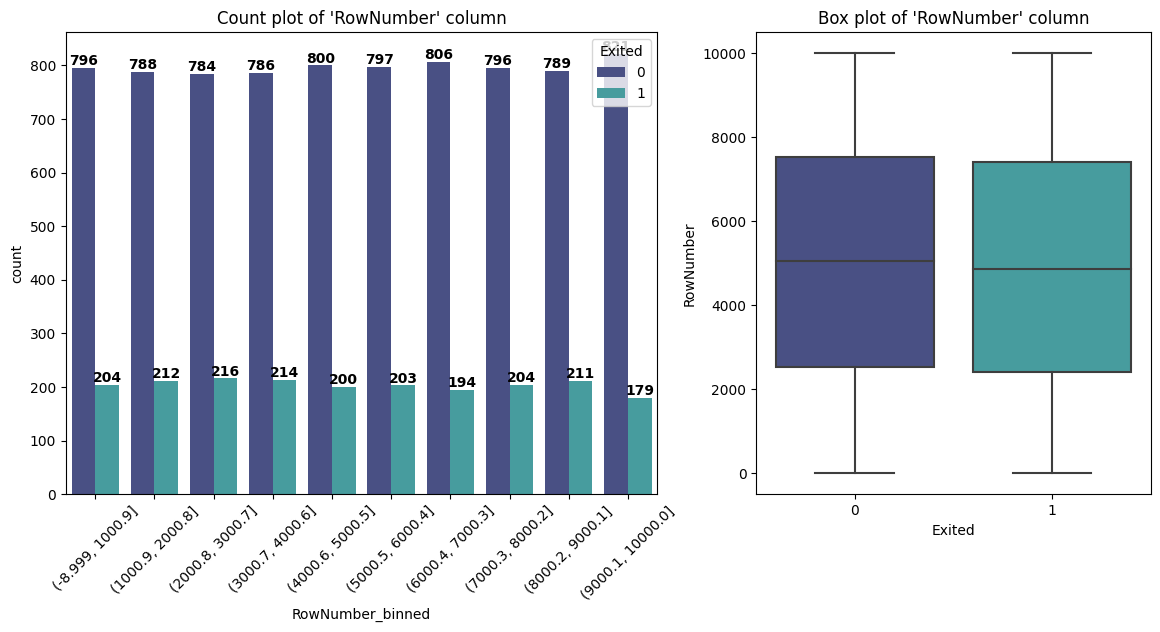

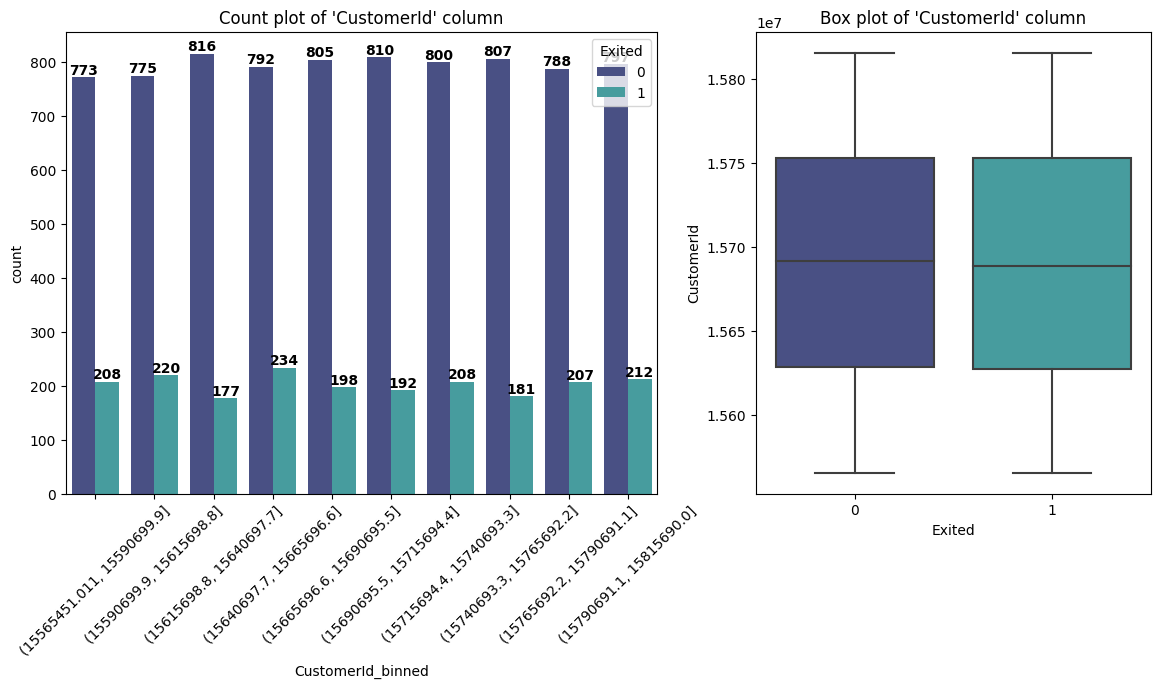

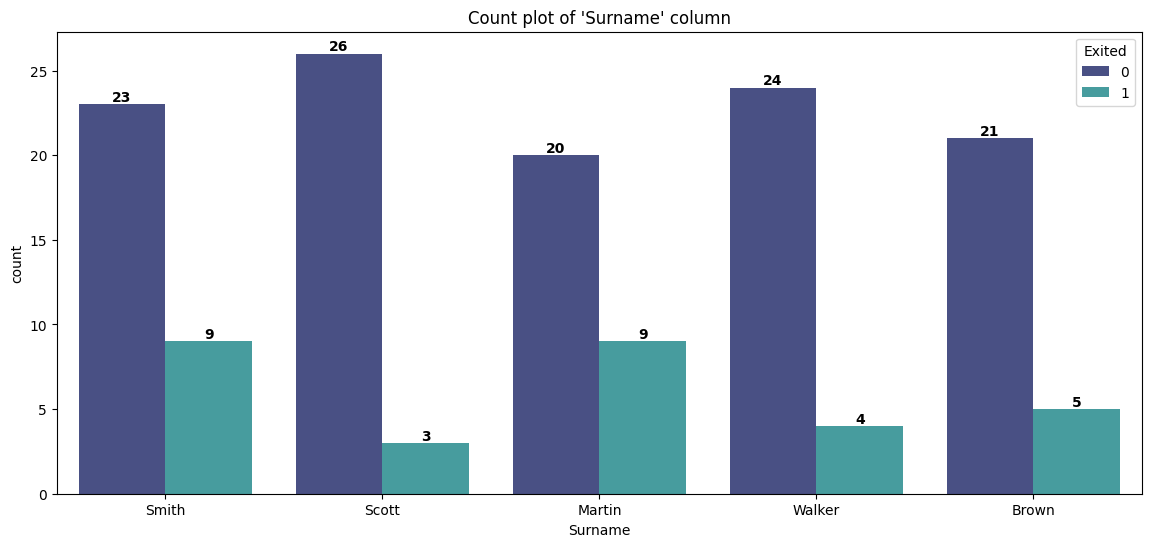

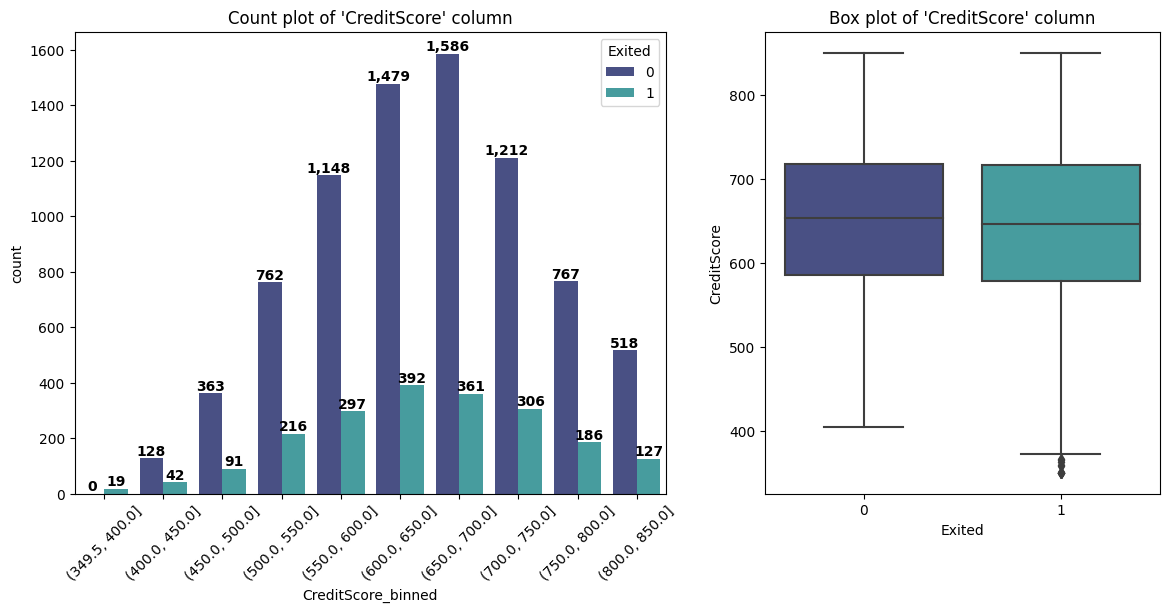

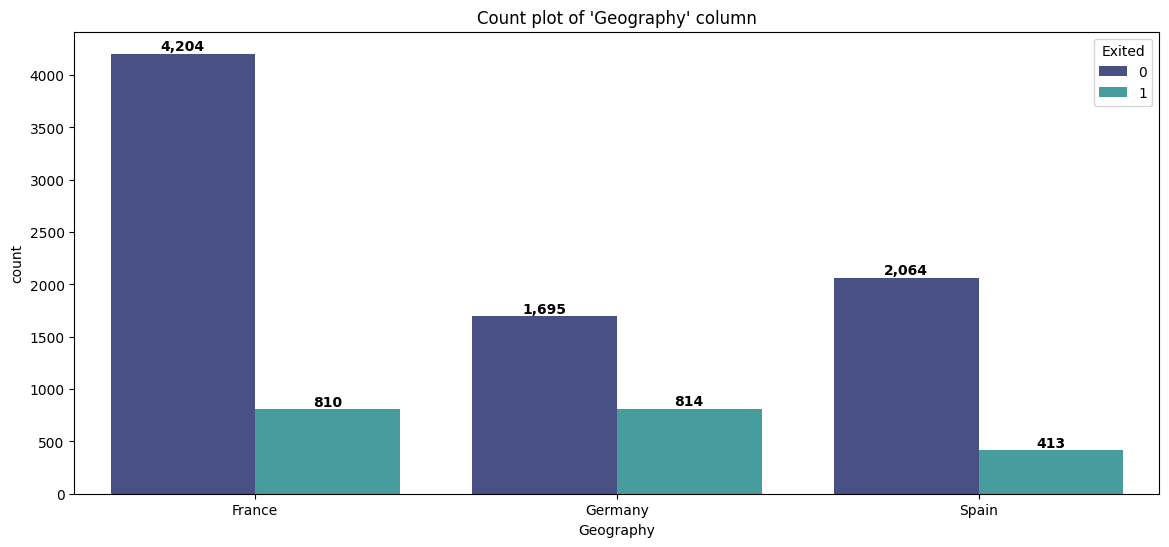

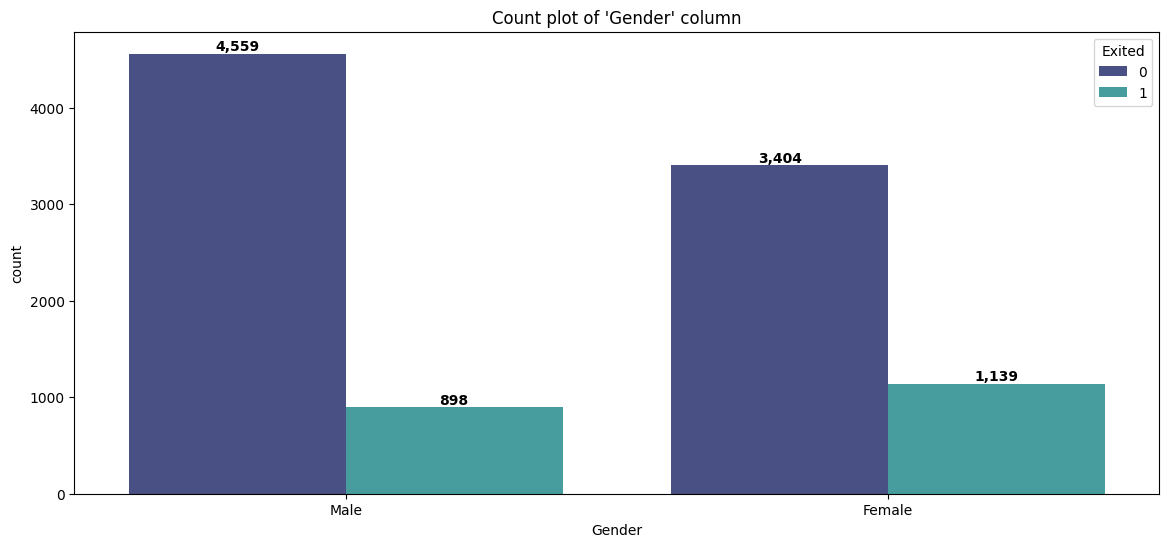

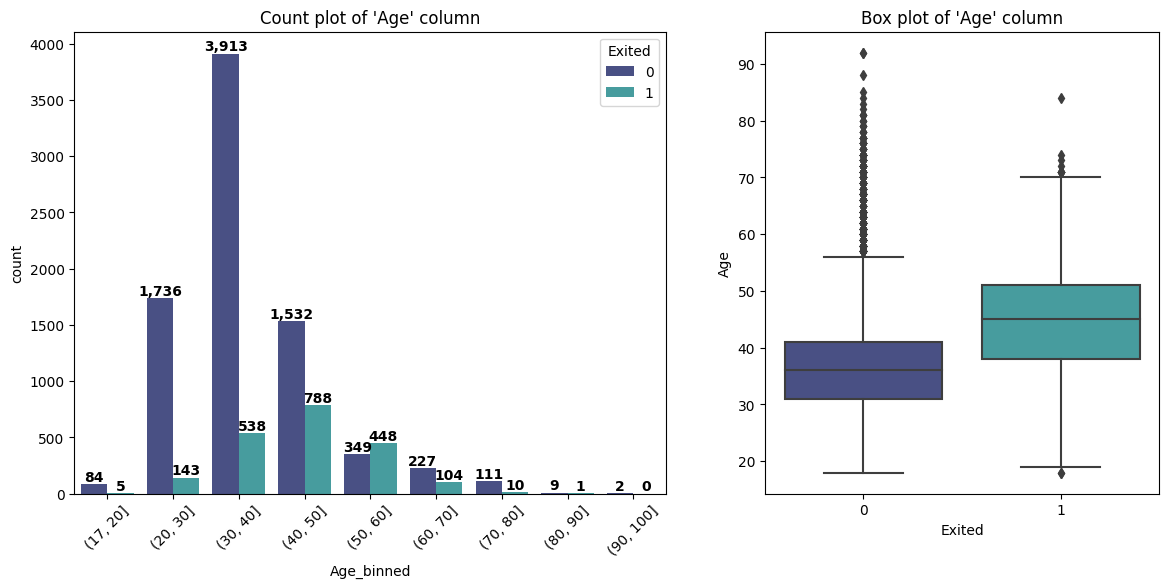

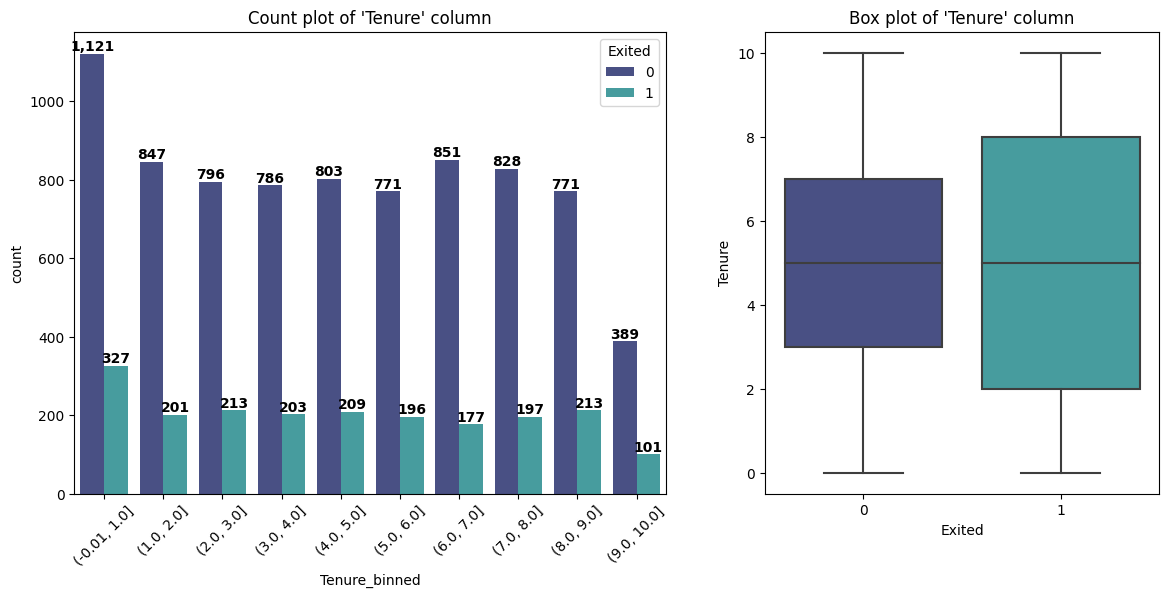

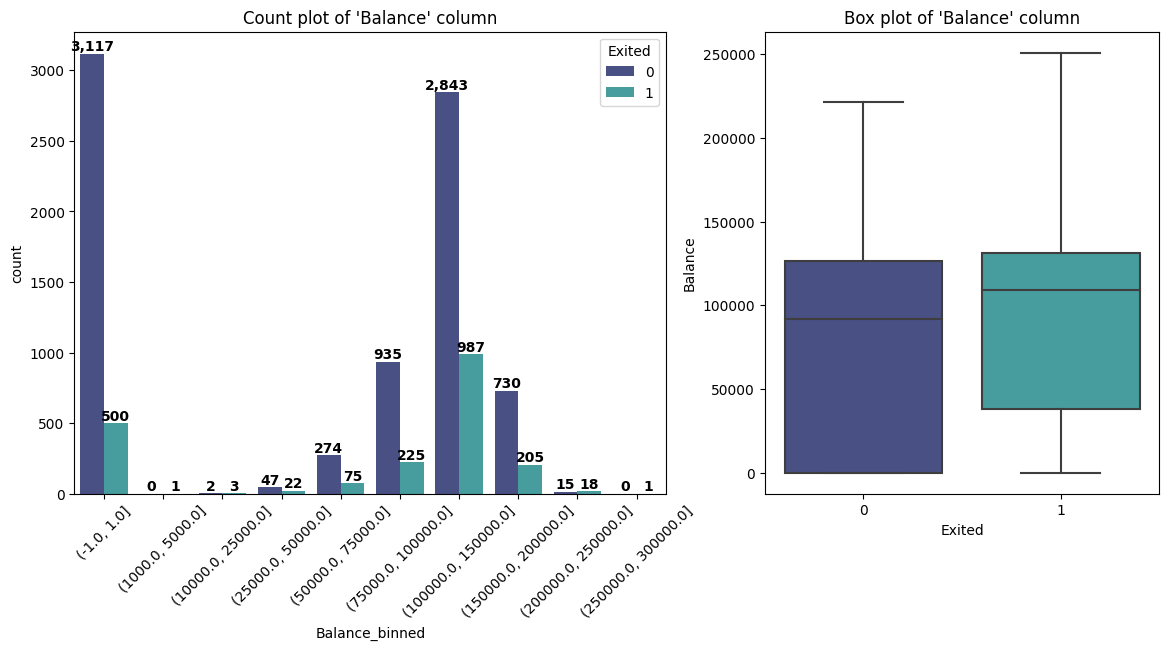

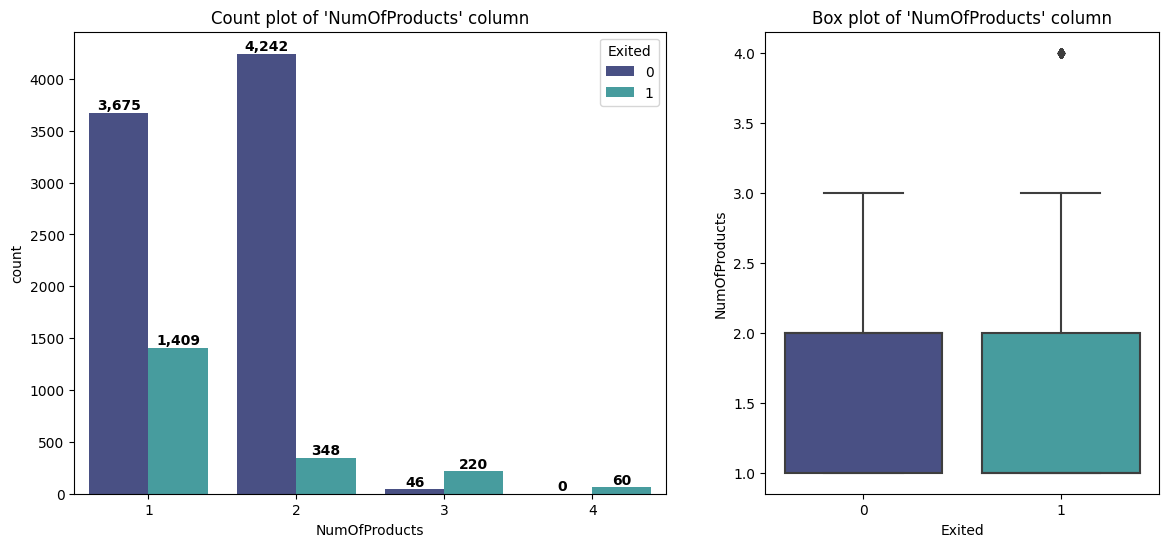

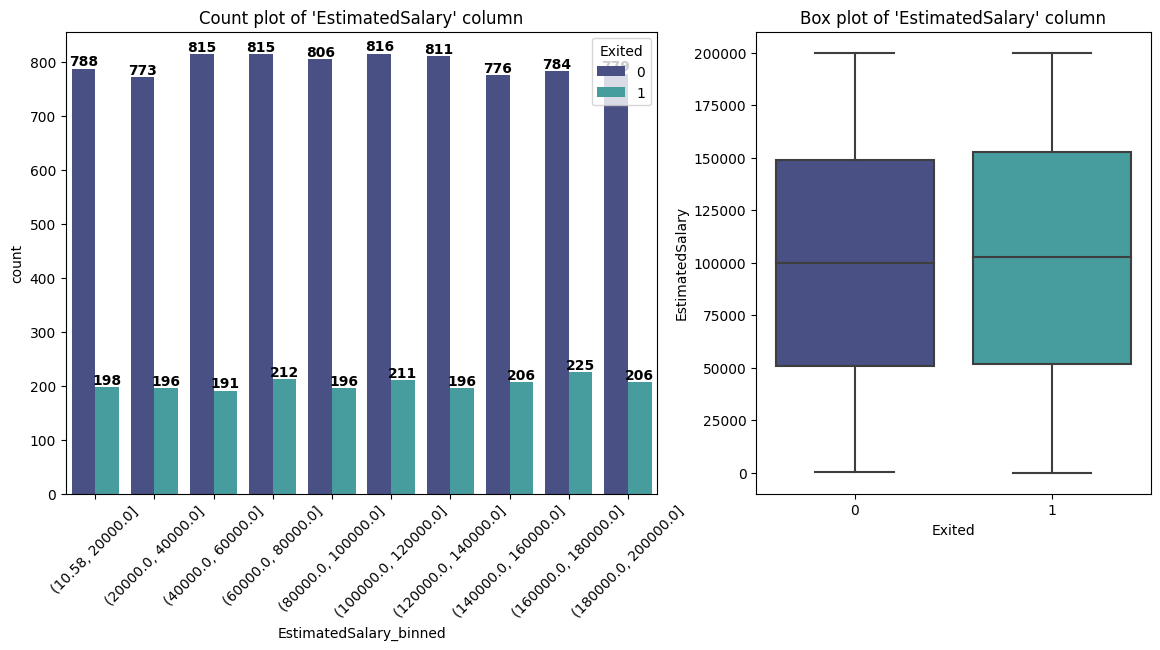

In [7]:
BankChurn.display_viz()

# Clean Dataset
* Removing columns
* Mapping Gender to integer with {'Female' : 0, 'Male' : 1}

In [8]:
BankChurn.clean_dataset()
BankChurn.df[BankChurn.X_columns]

CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0             619    France       0   42       2       0.00              1   
1             608     Spain       0   41       1   83807.86              1   
2             502    France       0   42       8  159660.80              3   
3             699    France       0   39       1       0.00              2   
4             850     Spain       0   43       2  125510.82              1   
...           ...       ...     ...  ...     ...        ...            ...   
9995          771    France       1   39       5       0.00              2   
9996          516    France       1   35      10   57369.61              1   
9997          709    France       0   36       7       0.00              1   
9998          772   Germany       1   42       3   75075.31              2   
9999          792    France       0   28       4  130142.79              1   

      HasCrCard  IsActiveMember  EstimatedSalary  
0             1               1        101348.88  
1             0               1        112542.58  
2             1               0        113931.57  
3             0               0         93826.63  
4             1               1         79084.10  
...         ...             ...              ...  
9995          1               0         96270.64  
9996          1               1        101699.77  
9997          0               1         42085.58  
9998          1               0         92888.52  
9999          1               0         38190.78  

[10000 rows x 10 columns]

# Model Training

### Get models and parameters

In [9]:
BankChurn.get_models_parameters()
BankChurn.models_and_parameters

{'Logistic Regression': {'model': LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
  'params': {'classifier__C': [0.1, 1, 10],
   'classifier__penalty': ['l2', 'l1'],
   'classifier__solver': ['liblinear']}},
 'SVM': {'model': SVC(probability=True, random_state=42, verbose=0),
  'params': {'classifier__C': [0.1, 1, 5, 8, 10],
   'classifier__kernel': ['linear', 'rbf', 'poly']}},
 'Random Forest': {'model': RandomForestClassifier(n_jobs=-1, random_state=42, warm_start=True),
  'params': {'classifier__n_estimators': [50, 75, 100],
   'classifier__max_depth': [None, 5, 10],
   'classifier__min_samples_leaf': [1, 2, 4]}},
 'LightGBM': {'model': LGBMClassifier(n_jobs=-1, random_state=42, verbose=0),
  'params': {'classifier__n_estimators': [25, 50, 75],
   'classifier__num_leaves': [3, 5, 7],
   'classifier__learning_rate': [0.1, 0.2]}},
 'XGBoost': {'model': XGBClassifier(base_score=None, booster=None, callbacks=None,
                colsample_bylevel=None, colsample_bynode=N

# Feature Engineering
* Data transformation for numerical variable by scaling Min-Max
* Data transformation for categorical variable by one-hot encoding
* Train test split by 'gender' and 'exited'

In [10]:
BankChurn.feature_engineering()

# Model Training
* Using model_and_parameters for Cross Validation and Hyperparameter Tuning

In [11]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore")
from sklearn.exceptions import DataConversionWarning, FitFailedWarning

warnings.filterwarnings("ignore", category=DataConversionWarning)
warnings.filterwarnings("ignore", category=FitFailedWarning)

BankChurn.model_training()

Logistic Regression


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:1211: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 4.
  

CV Results:
              precision    recall  f1-score   support

   Not Churn       0.90      0.72      0.80      6370
       Churn       0.38      0.69      0.50      1630

    accuracy                           0.71      8000
   macro avg       0.64      0.71      0.65      8000
weighted avg       0.80      0.71      0.74      8000

Balanced Accuracy: 0.7050
ROC AUC: 0.7688
Test Set Results:
              precision    recall  f1-score   support

   Not Churn       0.90      0.72      0.80      1593
       Churn       0.39      0.69      0.50       407

    accuracy                           0.72      2000
   macro avg       0.64      0.70      0.65      2000
weighted avg       0.80      0.72      0.74      2000

Balanced Accuracy: 0.7043
ROC AUC: 0.7802
SVM
CV Results:
              precision    recall  f1-score   support

   Not Churn       0.94      0.79      0.86      6370
       Churn       0.50      0.79      0.61      1630

    accuracy                           0.79      800

# Model Explainability


Global Feature Importance


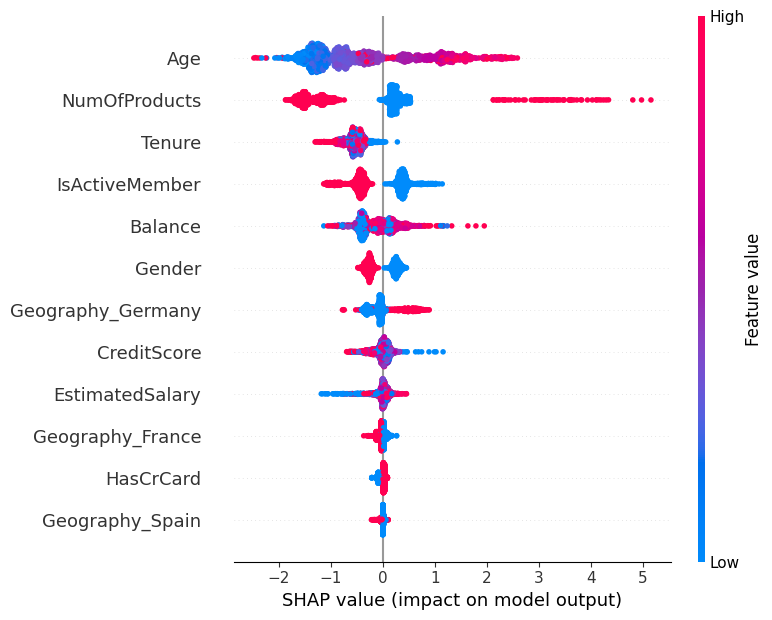

None


Local Feature Importance - Non Churned Customer



Local Feature Importance - Churned Customer


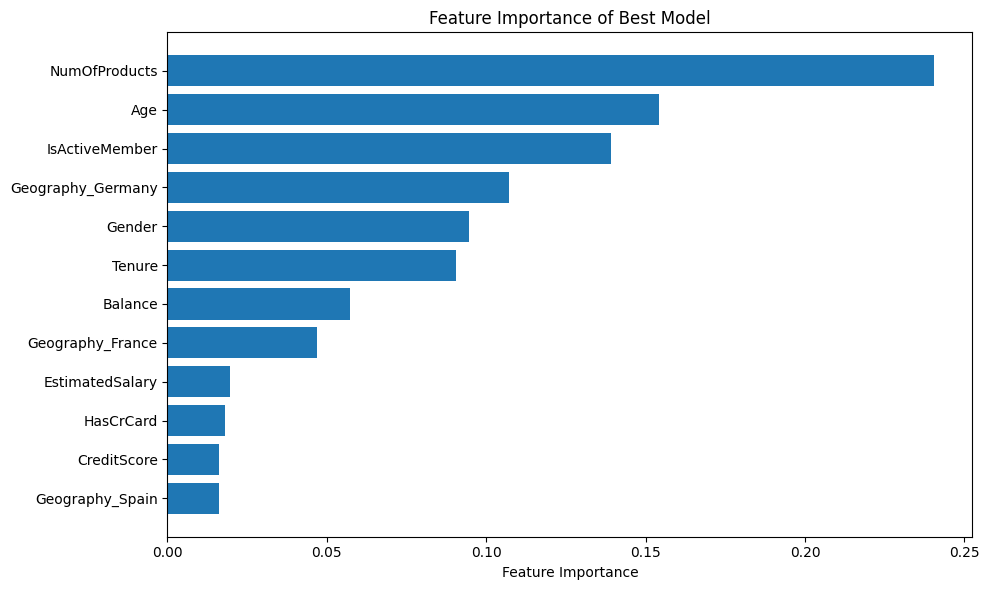

In [12]:
BankChurn.model_explainability()